In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from math import floor
import numpy as np
import os
plt.rcParams['figure.figsize'] = (10.0, 6.0)
os.environ['CC'] = 'gcc-7'

# Cubic Spline Interpolator

In [25]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [35]:
%%cython -3 --compile-args=-fopenmp --link-args=-fopenmp --force
import cython
import numpy as np
cimport cython
cimport numpy as np
from libc.math cimport floor, sqrt
from libc.stdlib cimport malloc, free
from cython cimport parallel

ctypedef np.float64_t dtype_t

@cython.boundscheck(False)
@cython.cdivision(True)
cpdef double[:] compute_interpolants( int n, double[:] f ):
        
    cdef int num_terms
    cdef double a,b, r_a, r_b, d1, coeff_tmp
    cdef Py_ssize_t i
    cdef double[:] coeffs
    cdef double[:] d
    
    num_terms = 27
    
    coeffs = np.zeros(n+3)
    d = np.zeros(n)

    a   = sqrt((2.0+sqrt(3.0))/6.0)
    r_a = 1.0/a
    b   = sqrt((2.0-sqrt(3.0))/6.0)
    b_a = b/a

    d1 = f[0]
    coeff_tmp = 1.0
    for i in range(num_terms):
        coeff_tmp *= (-b_a)
        d1 += coeff_tmp*f[n-2-i]

    d[0] = d1*r_a
    for i in range(1,n-1):
        d[i] = r_a*(f[i] - b*d[i-1])
        
    d1        = d[-2]
    coeff_tmp = 1.0
    for i in range(num_terms):
        coeff_tmp *= (-b_a)
        d1 += coeff_tmp*d[i]

    coeffs[n-1] = d1*r_a
    
    for i in range(n-2, 0, -1):
        coeffs[i] = r_a*(d[i-1] - b*coeffs[i+1])

    coeffs[0]  = coeffs[-4]
    coeffs[-1:-4:-1] = coeffs[3:0:-1]
        
    return coeffs



@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef double interpolate( 
    double[:] coeffs, 
    int n,
    double xmin, 
    double xmax, 
    double x ) nogil:
        
    cdef double rh, dx, cdx, cell
    cdef double cim1, ci, cip1, cip2
    cdef double t0, t1, t2, t3, t4
    cdef Py_ssize_t icell
    
    rdelta = (n-1) / (xmax - xmin)
    rh  = rdelta
    
    t0      = (x-xmin)*rh
    cell    = floor(t0)
    dx      = t0 - cell
    cdx     = 1.0 - dx
    icell   = int(cell)
    cim1    = coeffs[icell]
    ci      = coeffs[icell+1]
    cip1    = coeffs[icell+2]
    cip2    = coeffs[icell+3]
    t1      = 3.0*ci
    t3      = 3.0*cip1
    t2      = cdx*(cdx*(cdx*(cim1 - t1) + t1) + t1) + ci
    t4      =  dx*( dx*( dx*(cip2 - t3) + t3) + t3) + cip1
            
    return (t2 + t4) / 6.0

@cython.boundscheck(False)
def advection_x(np.ndarray [dtype_t, ndim=2] f, 
                np.ndarray [dtype_t, ndim=1] x,
                int nv, int nx, 
                double xmin, double xmax, 
                np.ndarray [dtype_t, ndim=1] v,
                double dt):
    
    cdef double[:] coeffs
    cdef double x_new
    cdef Py_ssize_t i, j

    for j in range(nv):
        coeffs = compute_interpolants(nx, f[j,:])        
        for i in range(nx):
            x_new = x[i] - dt * v[j]
            x_new = xmin + ( x_new - xmin)%(xmax-xmin)
            f[j,i] = interpolate(coeffs, nx, xmin, xmax, x_new)
    return f

@cython.boundscheck(False)
def advection_v(np.ndarray [dtype_t, ndim=2] f, 
                np.ndarray [dtype_t, ndim=1] v, 
                int nx, int nv, 
                double vmin, double vmax, 
                double[:] e, 
                double dt):
    
    cdef double[:] coeffs 

    cdef Py_ssize_t i, j
    cdef double v_new
    for i in range(nx):
        coeffs = compute_interpolants(nv, f[:,i] )       
        for j in range(nv):
            v_new = v[j] - dt * e[i] 
            v_new = vmin + (v_new - vmin)%(vmax-vmin) #(b + (a%b)) % b
            f[j,i] = interpolate(coeffs, nv, vmin, vmax, v_new)
    return f
            



In file included from /usr/local/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1809:0,
                 from /usr/local/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /usr/local/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /Users/navaro/.ipython/cython/_cython_magic_eca041ddd2a977f83723c9e5934640ec.c:562:
/usr/local/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^~~~~~~


## Interpolation test

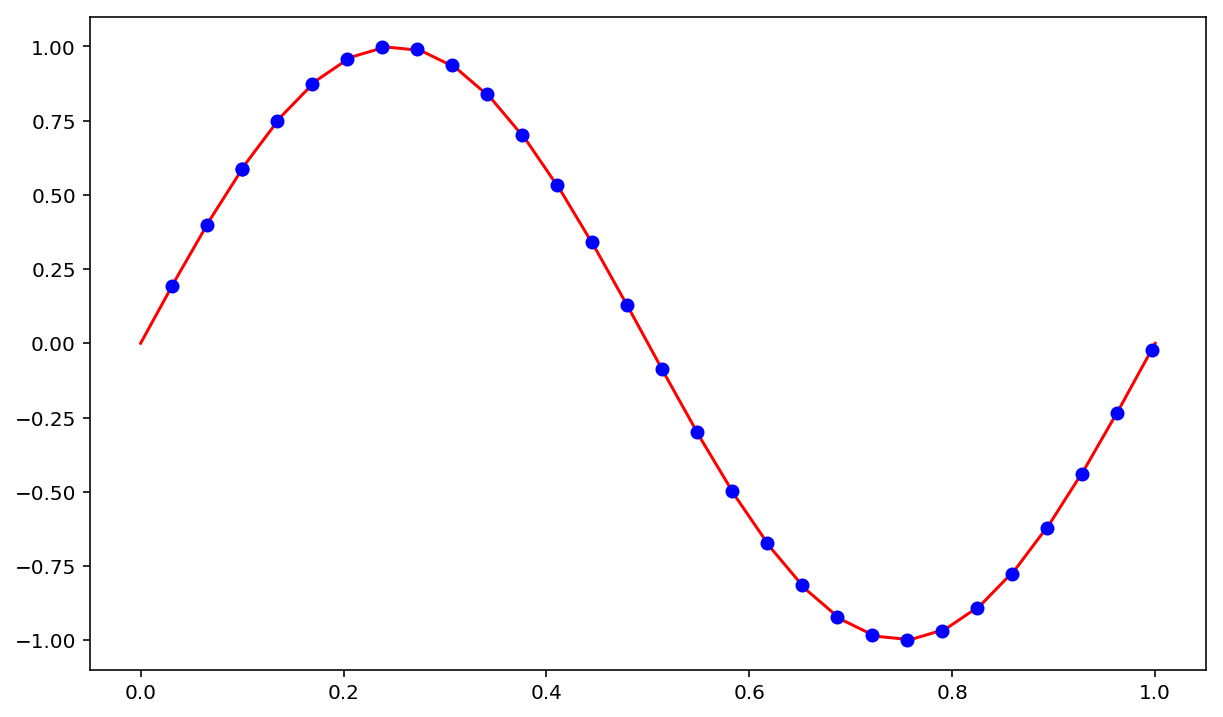

In [36]:
n =30
xmin, xmax = 0,1
x = np.linspace(xmin,xmax,n)
y = np.sin(x*2*np.pi)
x_new = np.zeros(n)
y_new = np.zeros(n)
coeffs = compute_interpolants(n, y) # compute spline coefficients
for i in range(n):
    x_new[i] = x[i] + 0.1   # x displacement of 0.1
    x_new[i] = xmin + ( x_new[i] - xmin)%(xmax-xmin) # apply periodic boundary conditions
    y_new[i] = interpolate(coeffs, n, xmin, xmax, x_new[i])
plt.plot(x, y, 'r-', x_new, y_new,'bo');

# Vlasov-Poisson equation
We consider the dimensionless Vlasov-Poisson equation for one species
with a neutralizing background.

$$ 
\frac{\partial f}{\partial t}+ v\cdot \nabla_x f + E(t,x) \cdot \nabla_v f = 0, \\
- \Delta \phi = 1 - \rho, E = - \nabla \phi \\
\rho(t,x)  =  \int f(t,x,v)dv.
$$





In [37]:
import progressbar
from scipy.fftpack import fft, ifft

class VlasovPoisson: # Backward Semi-Lagragian 
     
    def __init__(self, xmin, xmax, nx, vmin, vmax, nv):
        
        self.nx = nx
        self.x, self.dx = np.linspace(xmin, xmax, nx, retstep=True )
        self.nv = nv
        self.v, self.dv = np.linspace(vmin, vmax, nv, retstep=True)

        self.f = np.zeros((nx,nv))
            
        # Modes for Poisson equation
        self.modes = np.zeros(nx)
        k =  2* np.pi / (xmax - xmin)
        self.modes[:nx//2] = k * np.arange(nx//2)
        self.modes[nx//2:] = - k * np.arange(nx//2,0,-1)
        self.modes += self.modes == 0 # avoid division by zero 
        self.xmin = xmin
        self.xmax = xmax
        self.vmin = vmin
        self.vmax = vmax
        
        self.interp_x = np.vectorize(interpolate)
        self.interp_v = np.vectorize(interpolate)

    def advection_x(self, dt):
        
        self.f = advection_x( self.f, self.x, self.nv, self.nx, 
                             self.xmin, self.xmax, self.v, dt)

    def advection_v(self, e, dt):
        
        self.f = advection_v(self.f, self.v, self.nx, self.nv, 
                             self.vmin, self.vmax, e, dt)
            
    def compute_rho(self):
        return  self.dv * np.sum(self.f, axis=0)
            
    def compute_e(self, rho):
        # compute Ex using that ik*Ex = rho
        rhok = fft(rho)/self.modes
        return np.real(ifft(-1j*rhok))
    
    def run(self, f, nstep, dt):
        nrj = []
        self.f = f
        self.advection_x(0.5*dt)
        bar = progressbar.ProgressBar()
        for istep in bar(range(nstep)):
            rho = self.compute_rho()
            e = self.compute_e(rho)
            self.advection_v(e, dt)
            self.advection_x(dt)
            nrj.append( 0.5*np.log(np.sum(e*e)*self.dx))
            
        return nrj

# Bump On Tail

In [38]:
alpha = 0.03
kx  = 0.3
n = 1
Lx = 2 * np.pi * n / kx
sim = VlasovPoisson(xmin = 0.0, xmax = Lx, 
                    nx = 512,
             vmin = -9., vmax = 9., nv = 512)

X, V = np.meshgrid(sim.x, sim.v)

f = (1.0+alpha*np.cos(kx*X)) / (10*np.sqrt(2*np.pi))
f *= (9*np.exp(-0.5*V*V)+2*np.exp(-2*(V-4.5)**2))


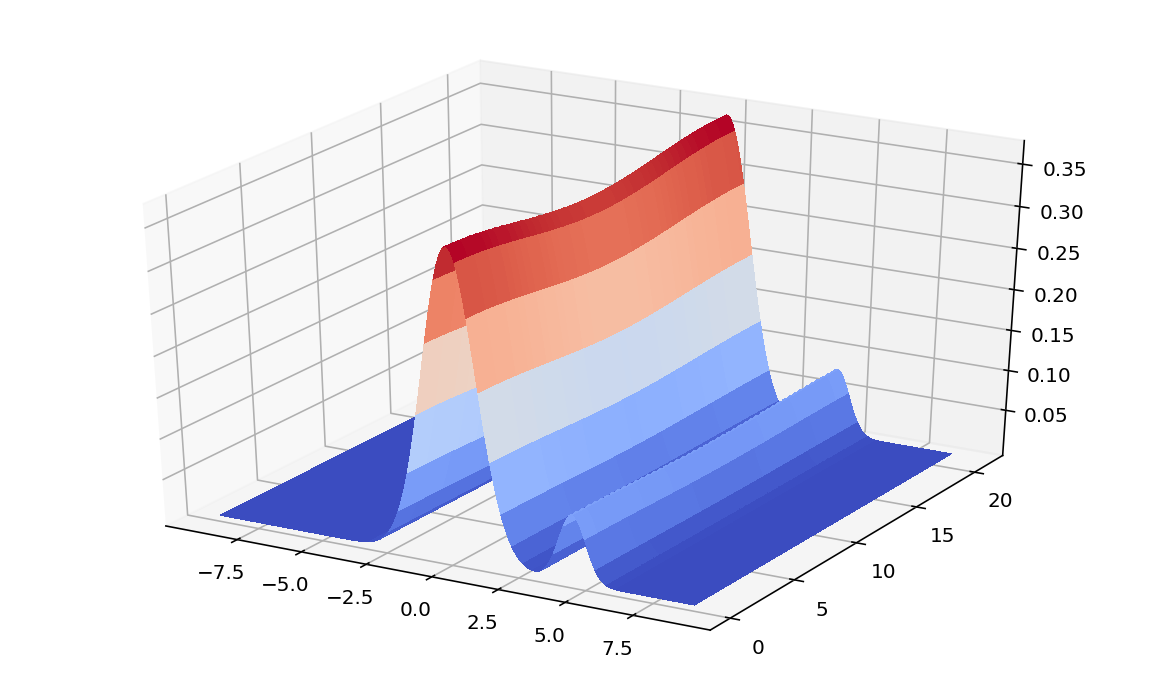

In [39]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(V, X, f, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


100% (500 of 500) |#######################| Elapsed Time: 0:00:12 Time: 0:00:12


CPU times: user 12.9 s, sys: 161 ms, total: 13.1 s
Wall time: 13 s


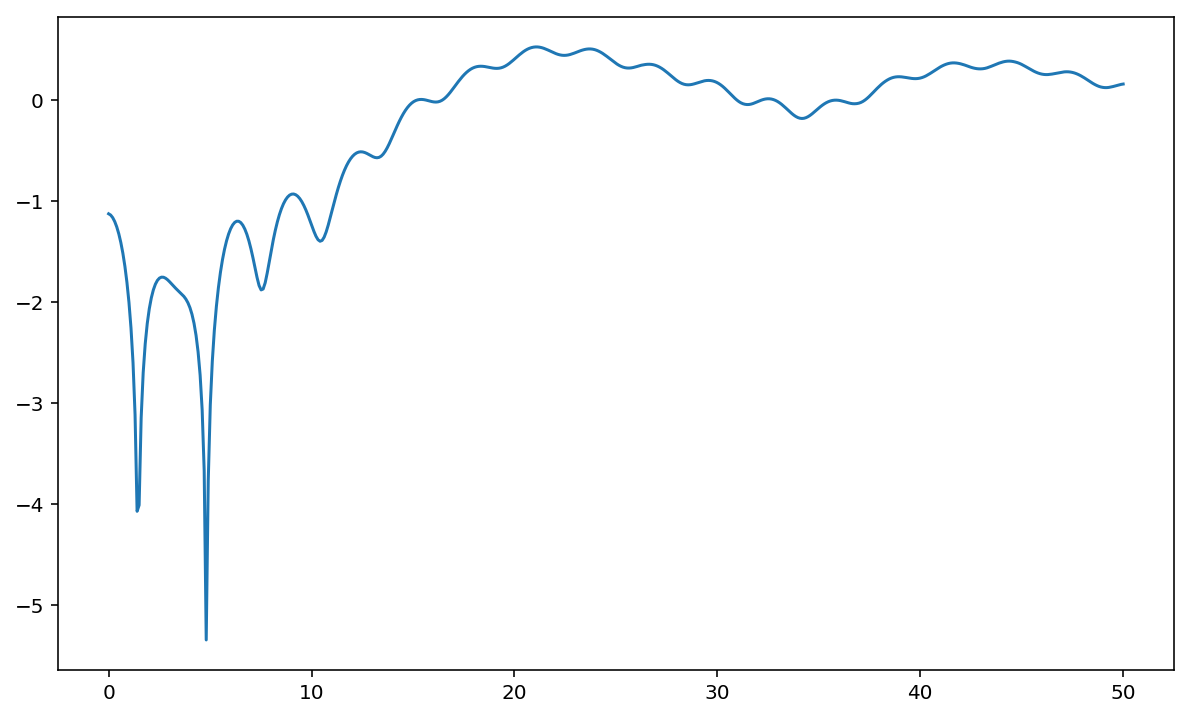

In [40]:
%%time
nstep = 500
t, dt = np.linspace(0.0, 50.0, nstep, retstep=True)
nrj = sim.run( f, nstep, dt)

plt.plot(t, nrj)

In [ ]:
%%cython -3 --compile-args=-fopenmp --link-args=-lgomp --force

import cython
cimport numpy as np
from cython.parallel cimport parallel, threadid

@cython.boundscheck(False)
@cython.wraparound(False)
cdef int set_array_view(int[:] x, int value) nogil: 
    cdef Py_ssize_t i
    
    for i in range(x.shape[0]):
        x[i] = value
    return 0

@cython.boundscheck(False)
@cython.wraparound(False)
def ompwork(int[:] x not None):
    cdef unsigned int thread_id, h
    cdef int n = x.shape[0]
    h = n // 4
    with nogil, parallel(num_threads=4):
       thread_id = threadid()
       set_array_view(x[thread_id*h:(thread_id+1)*h],thread_id)
        
    return x

In [ ]:
import numpy as np
x = np.ones(12,dtype=np.int32)
ompwork(x);

In [154]:
x

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3], dtype=int32)